# Consumer Complaints NLP models

The objective is to predict what product the complaint is about.  These three models have been created to compare the performance: LSMT model, Attention model and LSTM with attention layer

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Dense, Input, GlobalAveragePooling1D, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from sklearn.metrics import confusion_matrix
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
from keras import backend as K
from keras.engine.topology import Layer
from sklearn.metrics import classification_report

Using TensorFlow backend.


In [2]:
df = pd.read_csv('consumer_complaints.csv')

In [3]:
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,3/12/2014,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,M&T BANK CORPORATION,MI,48382,NaN,NaN,Referral,3/17/2014,Closed with explanation,Yes,No,759217
1,10/1/2016,Credit reporting,NaN,Incorrect information on credit report,Account status,I have outdated information on my credit repor...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",AL,352XX,NaN,Consent provided,Web,10/5/2016,Closed with explanation,Yes,No,2141773
2,10/17/2016,Consumer Loan,Vehicle loan,Managing the loan or lease,NaN,I purchased a new car on XXXX XXXX. The car de...,NaN,"CITIZENS FINANCIAL GROUP, INC.",PA,177XX,Older American,Consent provided,Web,10/20/2016,Closed with explanation,Yes,No,2163100
3,6/8/2014,Credit card,NaN,Bankruptcy,NaN,NaN,NaN,AMERICAN EXPRESS COMPANY,ID,83854,Older American,NaN,Web,6/10/2014,Closed with explanation,Yes,Yes,885638
4,9/13/2014,Debt collection,Credit card,Communication tactics,Frequent or repeated calls,NaN,NaN,"CITIBANK, N.A.",VA,23233,NaN,NaN,Web,9/13/2014,Closed with explanation,Yes,Yes,1027760


## Data cleansing and normalization

In [4]:
df = df[~df['Consumer complaint narrative'].isna()]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199970 entries, 1 to 903982
Data columns (total 18 columns):
Date received                   199970 non-null object
Product                         199970 non-null object
Sub-product                     147788 non-null object
Issue                           199970 non-null object
Sub-issue                       113532 non-null object
Consumer complaint narrative    199970 non-null object
Company public response         95433 non-null object
Company                         199970 non-null object
State                           199407 non-null object
ZIP code                        199389 non-null object
Tags                            33446 non-null object
Consumer consent provided?      199970 non-null object
Submitted via                   199970 non-null object
Date sent to company            199970 non-null object
Company response to consumer    199970 non-null object
Timely response?                199970 non-null object
Consumer di

In [6]:
df.Product.value_counts()

Debt collection                                                                 47915
Mortgage                                                                        36582
Credit reporting                                                                31592
Credit card                                                                     18842
Bank account or service                                                         14888
Credit reporting, credit repair services, or other personal consumer reports    14671
Student loan                                                                    13304
Consumer Loan                                                                    9474
Credit card or prepaid card                                                      3355
Checking or savings account                                                      2142
Payday loan                                                                      1748
Money transfers                                       

Label Consolidation

In [7]:

df.loc[df['Product'] == 'Credit reporting', 'Product'] = 'Credit reporting, credit repair services, or other personal consumer reports'
df.loc[df['Product'] == 'Credit card', 'Product'] = 'Credit card or prepaid card'
df.loc[df['Product'] == 'Payday loan', 'Product'] = 'Payday loan, title loan, or personal loan'
df.loc[df['Product'] == 'Virtual currency', 'Product'] = 'Money transfer, virtual currency, or money service'
df = df[df.Product != 'Other financial service']

In [8]:
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text


clean_text('''An ??? account on my && credit report has a mistaken date. I / / mailed in a debt validation letter to allow fix XXXX to correct the information. I received a letter in the mail, stating that Experian received my correspondence and found it to be " suspicious '' and that " I did n't write it ''. Experian 's letter is worded to imply that I am incapable of writing my own letter. I was deeply offended by this implication. 
I called Experian to figure out why my letter was so suspicious. I spoke to a representative who was incredibly unhelpful, She did not effectively answer any questions I asked of her, and she kept ignoring what I was saying regarding the offensive letter and my dispute process. I feel the representative did what she wanted to do, and I am not satisfied. It is STILL not clear to me why I received this letter. I typed this letter, I signed this letter, and I paid to mail this letter, yet Experian willfully disregarded my lawful request. 
I am disgusted with this entire situation, and I would like for my dispute to be handled appropriately, and I would like for an Experian representative to contact me and give me a real explanation for this letter.''')

'account credit report mistaken date mailed debt validation letter allow fi correct information received letter mail stating eperian received correspondence found suspicious nt write eperian letter worded imply incapable writing letter deeply offended implication called eperian figure letter suspicious spoke representative incredibly unhelpful effectively answer questions asked kept ignoring saying regarding offensive letter dispute process feel representative wanted satisfied still clear received letter typed letter signed letter paid mail letter yet eperian willfully disregarded lawful request disgusted entire situation would like dispute handled appropriately would like eperian representative contact give real eplanation letter'

In [9]:
df['Consumer complaint narrative'] = df['Consumer complaint narrative'].apply(clean_text)

df["Consumer complaint narrative"]

0         outdated information credit report previously ...
1         purchased new car car dealer called citizens b...
2         account credit report mistaken date mailed deb...
3         company refuses provide verification validatio...
4         complaint regards square two financial refer c...
                                ...                        
199673    son taken 2012 er visit insurance time hospita...
199674    13 without authorization bank america withdrew...
199675    account previously disputed sold towers area e...
199676    contacted email caliber home loans refinance c...
199677    debit included chapter bk almost two years let...
Name: Consumer complaint narrative, Length: 199678, dtype: object

In [10]:
def print_plot(index):
    example = df[df.index == index][['Consumer complaint narrative', 'Product']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Product:', example[1])

In [11]:
print_plot(10)

without provocation received notice credit line decreased nearly 100 available credit reduced rough amount available balance called question change provided nobdescript response referencing report understanding fcra entitled copy report refused citi given eplanation predatory affects utilization credit subjecting increase aprs etc higher cost credit without reason
Product: Credit card or prepaid card


In [12]:
print_plot(100)

recently sent letter company asking stop contacting regards whatever keep calling idea pertains
Product: Debt collection


(array([1.88782e+05, 1.05830e+04, 2.17000e+02, 5.80000e+01, 2.20000e+01,
        4.00000e+00, 4.00000e+00, 5.00000e+00, 1.00000e+00, 2.00000e+00]),
 array([   0. ,  251.6,  503.2,  754.8, 1006.4, 1258. , 1509.6, 1761.2,
        2012.8, 2264.4, 2516. ]),
 <a list of 10 Patch objects>)

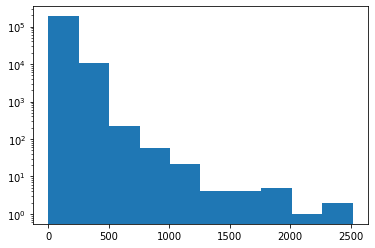

In [13]:
# Cut off text length is around 250
messagelength = df['Consumer complaint narrative'].apply(lambda x: len(x.split()))
plt.hist(messagelength, log = True)

Vectorize consumer complaints text, by turning each text into either a sequence of integers or into a vector.
Limit the data set to the top 5,0000 words.
Set the max number of words in each complaint at 250.

In [14]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 10

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Consumer complaint narrative'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 108069 unique tokens.


Truncate and pad the input sequences so that they are all in the same length for modeling.

In [15]:
X = tokenizer.texts_to_sequences(df['Consumer complaint narrative'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

print(X[0])

Shape of data tensor: (199678, 250)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0 

Converting categorical labels to numbers.

In [16]:
Y = pd.get_dummies(df['Product']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (199678, 13)


Train test split.

In [17]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(179710, 250) (179710, 13)
(19968, 250) (19968, 13)


## LSTM Modeling

* The first layer is the embedded layer that uses 10 length vectors to represent each word.
* SpatialDropout1D performs variational dropout in NLP models.
* The next layer is the LSTM layer with 20 memory units.
* The output layer must create 13 output values, one for each class.
* Activation function is softmax for multi-class classification. Because it is a multi-class classification problem, categorical_crossentropy is used as the loss function.

In [18]:
model_lstm = Sequential()
model_lstm.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
# model.add(SpatialDropout1D(0.2))
model_lstm.add(LSTM(20, dropout=0.2, recurrent_dropout=0.2))
model_lstm.add(Dense(13, activation='softmax'))
model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_lstm.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 250, 10)           500000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 20)                2480      
_________________________________________________________________
dense_1 (Dense)              (None, 13)                273       
Total params: 502,753
Trainable params: 502,753
Non-trainable params: 0
_________________________________________________________________
None


In [19]:
epochs = 5
batch_size = 64

history = model_lstm.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

model_lstm.save_weights("model_lstm.h5")
print("Saved model to disk")

Train on 161739 samples, validate on 17971 samples
Epoch 1/5
161739/161739 [==============================] - 888s 5ms/step - loss: 1.4799 - acc: 0.5042 - val_loss: 1.1053 - val_acc: 0.6657
Epoch 2/5
161739/161739 [==============================] - 857s 5ms/step - loss: 1.0363 - acc: 0.6811 - val_loss: 0.8584 - val_acc: 0.7413
Epoch 3/5
161739/161739 [==============================] - 937s 6ms/step - loss: 0.8473 - acc: 0.7451 - val_loss: 0.7390 - val_acc: 0.7768
Epoch 4/5
161739/161739 [==============================] - 842s 5ms/step - loss: 0.7286 - acc: 0.7825 - val_loss: 0.6674 - val_acc: 0.7996
Epoch 5/5
161739/161739 [==============================] - 855s 5ms/step - loss: 0.6400 - acc: 0.8098 - val_loss: 0.6010 - val_acc: 0.8182
Saved model to disk


In [20]:
model_lstm.load_weights("model_lstm.h5")

In [21]:
accr = model_lstm.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

19968/19968 [==============================] - 22s 1ms/step
Test set
  Loss: 0.602
  Accuracy: 0.819


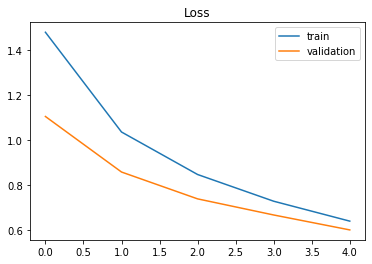

In [22]:
# The validation was improving during the entire course of training, may have improved with additional run time, but the rate of the improving was slowing down
# It would be nice to have more epoch to tell if it's going to be further imrpovements or it reached the minimum.
# But the available compute was used for other models

plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show();

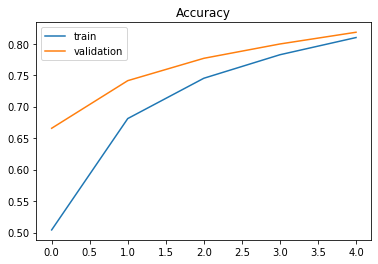

In [23]:

plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='validation')
plt.legend()
plt.show();

Test with new complaint.

In [24]:
new_complaint = ['I am a victim of identity theft and someone stole my identity and personal information to open up a Visa credit card account with Bank of America. The following Bank of America Visa credit card account do not belong to me : XXXX.']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model_lstm.predict(padded)
labels = ['Credit reporting, credit repair services, or other personal consumer reports', 'Debt collection', 'Mortgage', 'Credit card or prepaid card', 'Student loan', 'Bank account or service', 'Checking or savings account', 'Consumer Loan', 'Payday loan, title loan, or personal loan', 'Vehicle loan or lease', 'Money transfer, virtual currency, or money service', 'Money transfers', 'Prepaid card']
print(pred, labels[np.argmax(pred)])

[[4.4462454e-02 6.0598222e-03 2.5416366e-03 8.8223302e-01 2.2010159e-02
  2.5440903e-02 4.2294228e-04 5.9075718e-04 2.6230535e-03 4.0705141e-04
  1.3127763e-02 5.5942751e-06 7.4881842e-05]] Credit card or prepaid card


Apply confusion matrix.  

In [25]:
y_test_predict_lstm = model_lstm.predict(X_test)

In [26]:
y_test_predict_lstm[0]

array([1.3518851e-05, 1.5080772e-06, 4.2472355e-04, 2.6545185e-04,
       9.9045604e-01, 8.7097473e-03, 1.4046989e-06, 1.9911536e-06,
       5.0448980e-05, 1.6716383e-05, 8.1123630e-07, 3.8137037e-05,
       1.9395893e-05], dtype=float32)

In [27]:

# Despite the overall decent accuracy of 82%, the model has some shortcoming flaws.  In particular the category with 
# fewer data points such as Student loan, vehicle loan are never predicted by the model, instead the model get the 
# high accuracy on bigger categories and doesn't make attempt predict rare items. As such, the Micro avg Precision is 50%

print(classification_report(np.argmax(Y_test,axis=1), np.argmax(y_test_predict_lstm, axis=1),target_names=df['Product'].unique()))

                                                                              precision    recall  f1-score   support

Credit reporting, credit repair services, or other personal consumer reports       0.63      0.82      0.71      1439
                                                               Consumer Loan       0.00      0.00      0.00       229
                                                             Debt collection       0.58      0.59      0.58       941
                                                                    Mortgage       0.75      0.84      0.79      2178
                                                 Credit card or prepaid card       0.88      0.84      0.86      4624
                                                     Bank account or service       0.84      0.87      0.85      4852
                                                                Student loan       0.00      0.00      0.00        67
                                                       

C:\Users\Owner\Anaconda3\envs\tf\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[4 8 2 ... 5 4 4]
[5 8 2 ... 5 4 4]


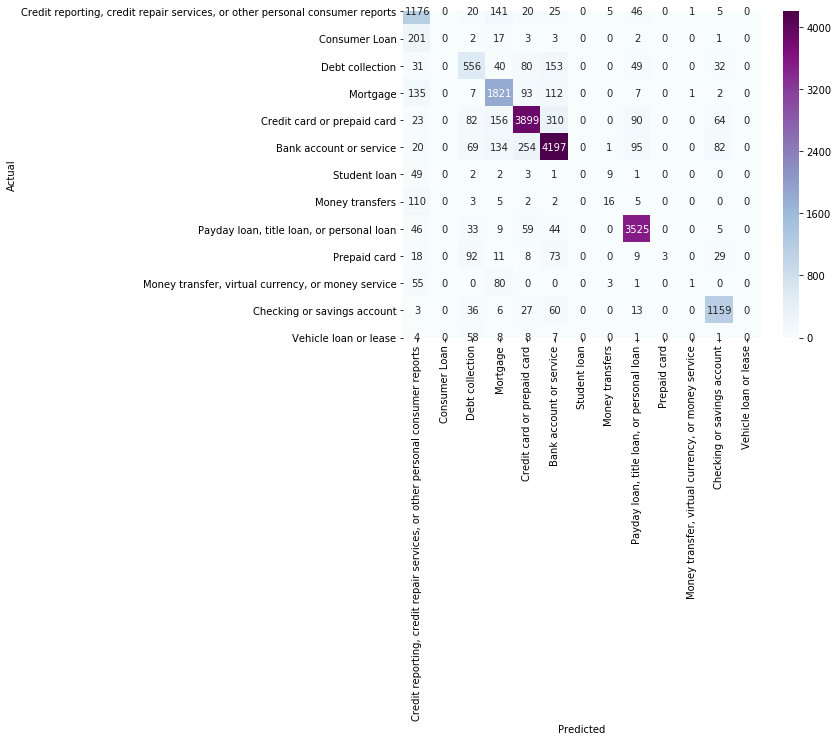

In [29]:

# Consumer loan, Student loan and Vehicle loan and lease have no prediction at all largely due to not enough training data.
# The prepaid card has been predicted as debt collection.  Debt is only a medium size category, for the prepaid card must have similar phrases as debt collection.

y_test_predict_label_lstm = np.argmax(np.asarray(y_test_predict_lstm), axis = 1)
y_test_true_label_lstm = np.argmax(np.asarray(Y_test), axis =1)

print(y_test_predict_label_lstm)

print(y_test_true_label_lstm)

result_table = confusion_matrix(y_test_true_label_lstm, y_test_predict_label_lstm)

fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(result_table, annot=True, fmt="d", cmap="BuPu",xticklabels=df['Product'].unique(),yticklabels=df['Product'].unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [189]:
Y_test_prob = model_lstm.predict_proba(X_test)

In [204]:
prob_9 = Y_test_prob[y_test_true_label_lstm == 9]
index = np.arange(len(Y_test_prob))[y_test_true_label_lstm == 9]
subindex = np.argmax(prob_9, axis = 0)[2]
df.iloc[index[subindex]]

Date received                                                           2/14/2017
Product                                                                  Mortgage
Sub-product                                           Conventional fixed mortgage
Issue                                    Loan modification,collection,foreclosure
Sub-issue                                                                     NaN
Consumer complaint narrative    got behind mortgage payments phh mortgage said...
Company public response                                                       NaN
Company                                         PHH Mortgage Services Corporation
State                                                                          MS
ZIP code                                                                    393XX
Tags                                                               Older American
Consumer consent provided?                                       Consent provided
Submitted via   


Position_Embedding and Attention is from https://github.com/foamliu/Self-Attention-Keras/blob/master/attention.py

In [69]:
class Position_Embedding(Layer):

    def __init__(self, size=None, mode='sum', **kwargs):
        self.size = size  
        self.mode = mode
        super(Position_Embedding, self).__init__(**kwargs)

    def call(self, x):
        if (self.size == None) or (self.mode == 'sum'):
            self.size = int(x.shape[-1])
        batch_size, seq_len = K.shape(x)[0], K.shape(x)[1]
        position_j = 1. / K.pow(10000., 2 * K.arange(self.size / 2, dtype='float32') / self.size)
        position_j = K.expand_dims(position_j, 0)
        position_i = K.cumsum(K.ones_like(x[:, :, 0]), 1) - 1 
        position_i = K.expand_dims(position_i, 2)
        position_ij = K.dot(position_i, position_j)
        position_ij = K.concatenate([K.cos(position_ij), K.sin(position_ij)], 2)
        if self.mode == 'sum':
            return position_ij + x
        elif self.mode == 'concat':
            return K.concatenate([position_ij, x], 2)

    def compute_output_shape(self, input_shape):
        if self.mode == 'sum':
            return input_shape
        elif self.mode == 'concat':
            return (input_shape[0], input_shape[1], input_shape[2] + self.size)



class Attention(Layer):

    def __init__(self, nb_head, size_per_head, **kwargs):
        self.nb_head = nb_head
        self.size_per_head = size_per_head
        self.output_dim = nb_head * size_per_head
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.WQ = self.add_weight(name='WQ',
                                  shape=(input_shape[0][-1], self.output_dim),
                                  initializer='glorot_uniform',
                                  trainable=True)
        self.WK = self.add_weight(name='WK',
                                  shape=(input_shape[1][-1], self.output_dim),
                                  initializer='glorot_uniform',
                                  trainable=True)
        self.WV = self.add_weight(name='WV',
                                  shape=(input_shape[2][-1], self.output_dim),
                                  initializer='glorot_uniform',
                                  trainable=True)
        super(Attention, self).build(input_shape)

    def Mask(self, inputs, seq_len, mode='mul'):
        if seq_len == None:
            return inputs
        else:
            mask = K.one_hot(seq_len[:, 0], K.shape(inputs)[1])
            mask = 1 - K.cumsum(mask, 1)
            for _ in range(len(inputs.shape) - 2):
                mask = K.expand_dims(mask, 2)
            if mode == 'mul':
                return inputs * mask
            if mode == 'add':
                return inputs - (1 - mask) * 1e12

    def call(self, x):
        if len(x) == 3:
            Q_seq, K_seq, V_seq = x
            Q_len, V_len = None, None
        elif len(x) == 5:
            Q_seq, K_seq, V_seq, Q_len, V_len = x
       
        Q_seq = K.dot(Q_seq, self.WQ)
        Q_seq = K.reshape(Q_seq, (-1, K.shape(Q_seq)[1], self.nb_head, self.size_per_head))
        Q_seq = K.permute_dimensions(Q_seq, (0, 2, 1, 3))
        K_seq = K.dot(K_seq, self.WK)
        K_seq = K.reshape(K_seq, (-1, K.shape(K_seq)[1], self.nb_head, self.size_per_head))
        K_seq = K.permute_dimensions(K_seq, (0, 2, 1, 3))
        V_seq = K.dot(V_seq, self.WV)
        V_seq = K.reshape(V_seq, (-1, K.shape(V_seq)[1], self.nb_head, self.size_per_head))
        V_seq = K.permute_dimensions(V_seq, (0, 2, 1, 3))
       
        A = K.batch_dot(Q_seq, K_seq, axes=[3, 3]) / self.size_per_head ** 0.5
        A = K.permute_dimensions(A, (0, 3, 2, 1))
        A = self.Mask(A, V_len, 'add')
        A = K.permute_dimensions(A, (0, 3, 2, 1))
        A = K.softmax(A)
       
        O_seq = K.batch_dot(A, V_seq, axes=[3, 2])
        O_seq = K.permute_dimensions(O_seq, (0, 2, 1, 3))
        O_seq = K.reshape(O_seq, (-1, K.shape(O_seq)[1], self.output_dim))
        O_seq = self.Mask(O_seq, Q_len, 'mul')
        return O_seq

    def compute_output_shape(self, input_shape):
        return (input_shape[0][0], input_shape[0][1], self.output_dim)

## Attention based seqence classification modeling


* Use the 10 vector embedding 13 category dense layer for output as seem in LSTM model
* Replaced LSTM layer with attention as Multi Headed attention model that is using the embedding directectly to generate keys, value and queries.  The final prediction is based on the pooled attention results.  

In [146]:
S_inputs = Input(shape=(250,), dtype='int32')

embeddings = Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1])(S_inputs)
embeddings = Position_Embedding()(embeddings)
#  Tried these values: 8,10 0.54, 0.83; 6, 8 0.56, 0.83; 10, 12 0.55,0.82; 8, 12 0.55,0.82; 10,13 0.54, 0.83; 10, 15, 0.54, 0.83
O_seq = Attention(8, 10)([embeddings, embeddings, embeddings])
O_seq = GlobalAveragePooling1D()(O_seq)
O_seq = Dropout(0.5)(O_seq)
outputs = Dense(13, activation='softmax')(O_seq)
model_attention = Model(inputs=S_inputs, outputs=outputs)

model_attention.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_attention.summary())


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           (None, 250)          0                                            
__________________________________________________________________________________________________
embedding_28 (Embedding)        (None, 250, 10)      500000      input_23[0][0]                   
__________________________________________________________________________________________________
position__embedding_23 (Positio (None, 250, 10)      0           embedding_28[0][0]               
__________________________________________________________________________________________________
attention_23 (Attention)        (None, 250, 80)      2400        position__embedding_23[0][0]     
                                                                 position__embedding_23[0][0]     
          

In [147]:
# Training using model_attention
epochs = 5
batch_size = 64

history_attention = model_attention.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

# save architecture
# model_json = model.to_json()
# with open("model.h5", "w") as json_file:
#     json_file.write(model_json)
    
# # reload model architecture
# from keras.models import load_model
# model = load_model('model.h5')
    
    
# serialize weights to HDF5
model_attention.save_weights("model_atten_6_8.h5")
print("Saved model to disk")

# # load coefficients
# model.load_weights(filename)

Train on 161739 samples, validate on 17971 samples
Epoch 1/5
161739/161739 [==============================] - 813s 5ms/step - loss: 1.1049 - acc: 0.6463 - val_loss: 0.7102 - val_acc: 0.7883
Epoch 2/5
161739/161739 [==============================] - 809s 5ms/step - loss: 0.6891 - acc: 0.7966 - val_loss: 0.6061 - val_acc: 0.8143
Epoch 3/5
161739/161739 [==============================] - 797s 5ms/step - loss: 0.6113 - acc: 0.8176 - val_loss: 0.5688 - val_acc: 0.8256
Epoch 4/5
161739/161739 [==============================] - 798s 5ms/step - loss: 0.5676 - acc: 0.8297 - val_loss: 0.5453 - val_acc: 0.8317
Epoch 5/5
161739/161739 [==============================] - 798s 5ms/step - loss: 0.5318 - acc: 0.8404 - val_loss: 0.5351 - val_acc: 0.8352
Saved model to disk


In [148]:
accr_attention = model_attention.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr_attention[0],accr_attention[1]))

19968/19968 [==============================] - 51s 3ms/step
Test set
  Loss: 0.540
  Accuracy: 0.831


In [180]:
y_predict_attention = model_attention.predict(X_test)

In [181]:
y_predict_attention[0]

array([2.2169816e-06, 3.0281785e-07, 5.4741121e-04, 3.3935122e-04,
       9.9158353e-01, 7.4244216e-03, 4.8527363e-07, 1.8994548e-07,
       2.8550221e-05, 8.5749025e-07, 9.6008840e-08, 9.7843931e-06,
       6.2755731e-05], dtype=float32)

In [182]:
# Modest improvement of 83% overall accuracy compared to LSTM model.  However, most of the improvement is not coming from the marginal improvement of the large category, instead it has major improvement of the smaller categories, as such the macro avg precision is 74%.  This is much more useful model for the task of sorting incoming messages.
 

print(classification_report(np.argmax(Y_test,axis=1), np.argmax(y_predict_attention, axis=1),target_names=df['Product'].unique()))

                                                                              precision    recall  f1-score   support

Credit reporting, credit repair services, or other personal consumer reports       0.69      0.80      0.74      1439
                                                               Consumer Loan       1.00      0.00      0.01       229
                                                             Debt collection       0.65      0.61      0.63       941
                                                                    Mortgage       0.80      0.81      0.81      2178
                                                 Credit card or prepaid card       0.86      0.86      0.86      4624
                                                     Bank account or service       0.82      0.87      0.85      4852
                                                                Student loan       0.94      0.24      0.38        67
                                                       

[4 8 2 ... 5 4 4]
[5 8 2 ... 5 4 4]


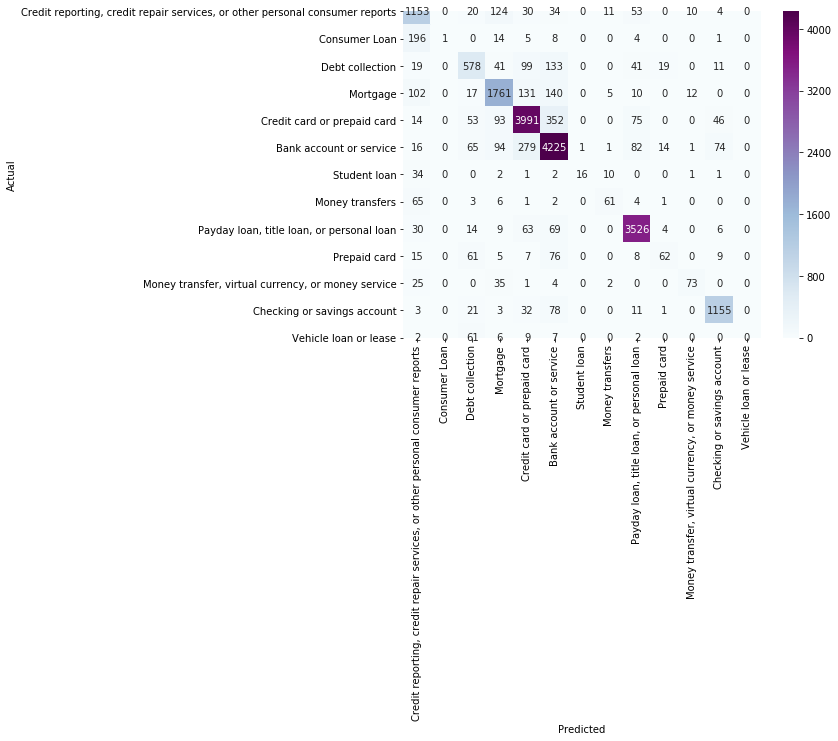

In [187]:
# Still some difficulties of some categories such as vehicle loan or lease and consumer loan, but debt collection and prepaid card results are much improved.

y_train_predict_label_attention = np.argmax(np.asarray(y_predict_attention), axis = 1)
y_train_true_label_attention = np.argmax(np.asarray(Y_test), axis =1)

print(y_train_predict_label_attention)

print(y_train_true_label_attention)

result_table = confusion_matrix(y_train_true_label_attention, y_train_predict_label_attention)

fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(result_table, annot=True, fmt="d", cmap="BuPu",xticklabels=df['Product'].unique(),yticklabels=df['Product'].unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## LSTM and Attention modeling

* Use the 10 vector embedding 13 category dense layer for output as seen in the other models
* Use LSTM on embedding input, pass results to the multi headed attention layer.  Keys, values and queries are all based on LSTM. 

In [103]:
S_inputs = Input(shape=(250,), dtype='int32')

embeddings = Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1])(S_inputs)
embeddings = Position_Embedding()(embeddings)
lstm = LSTM(20, return_sequences = True)(embeddings)
O_seq = Attention(8, 10)([lstm, lstm, lstm])
O_seq = GlobalAveragePooling1D()(O_seq)
#w/o dropout: 0.59, 0.81
O_seq = Dropout(0.5)(O_seq)
outputs = Dense(13, activation='softmax')(O_seq)
model_lstm_attention = Model(inputs=S_inputs, outputs=outputs)

model_lstm_attention.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_lstm_attention.summary())


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           (None, 250)          0                                            
__________________________________________________________________________________________________
embedding_20 (Embedding)        (None, 250, 10)      500000      input_16[0][0]                   
__________________________________________________________________________________________________
position__embedding_16 (Positio (None, 250, 10)      0           embedding_20[0][0]               
__________________________________________________________________________________________________
lstm_12 (LSTM)                  (None, 250, 20)      2480        position__embedding_16[0][0]     
__________________________________________________________________________________________________
attention_

In [104]:
# Training using model_attention
epochs = 5
batch_size = 64

history_attention = model_lstm_attention.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

# save architecture
# model_json = model.to_json()
# with open("model.h5", "w") as json_file:
#     json_file.write(model_json)
    
# # reload model architecture
# from keras.models import load_model
# model = load_model('model.h5')
    
    
# serialize weights to HDF5
model_lstm_attention.save_weights("model_lstm_20_atten_8_10.h5")
print("Saved model to disk")

# wiht dropout
#Loss: 0.597
#Accuracy: 0.818

# # load coefficients
# model.load_weights(filename)

Train on 161739 samples, validate on 17971 samples
Epoch 1/5
161739/161739 [==============================] - 1389s 9ms/step - loss: 1.2143 - acc: 0.5872 - val_loss: 0.8001 - val_acc: 0.7608
Epoch 2/5
161739/161739 [==============================] - 1370s 8ms/step - loss: 0.7586 - acc: 0.7781 - val_loss: 0.6956 - val_acc: 0.7923
Epoch 3/5
161739/161739 [==============================] - 1363s 8ms/step - loss: 0.6487 - acc: 0.8104 - val_loss: 0.6374 - val_acc: 0.8036
Epoch 4/5
161739/161739 [==============================] - 1344s 8ms/step - loss: 0.5792 - acc: 0.8295 - val_loss: 0.5930 - val_acc: 0.8182
Epoch 5/5
161739/161739 [==============================] - 1331s 8ms/step - loss: 0.5284 - acc: 0.8444 - val_loss: 0.5950 - val_acc: 0.8113
Saved model to disk


In [105]:
accr_lstm_attention = model_lstm_attention.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr_lstm_attention[0],accr_lstm_attention[1]))

19968/19968 [==============================] - 70s 4ms/step
Test set
  Loss: 0.599
  Accuracy: 0.815


In [183]:
y_predict_lstm_attention = model_lstm_attention.predict(X_test)

In [184]:
# Overall results are similar to the LSTM model, although slightly better macro avg precision result of 56%.  In theory this model is straightly more complex than the previous models, yet not perform better.  Either the additional complexity is only creating overfit or this model needs more training.

print(classification_report(np.argmax(Y_test,axis=1), np.argmax(y_predict_lstm_attention, axis=1),target_names=df['Product'].unique()))

                                                                              precision    recall  f1-score   support

Credit reporting, credit repair services, or other personal consumer reports       0.66      0.80      0.72      1439
                                                               Consumer Loan       0.00      0.00      0.00       229
                                                             Debt collection       0.63      0.57      0.60       941
                                                                    Mortgage       0.76      0.82      0.79      2178
                                                 Credit card or prepaid card       0.78      0.92      0.84      4624
                                                     Bank account or service       0.89      0.78      0.83      4852
                                                                Student loan       0.00      0.00      0.00        67
                                                       

[4 8 2 ... 5 4 4]
[5 8 2 ... 5 4 4]


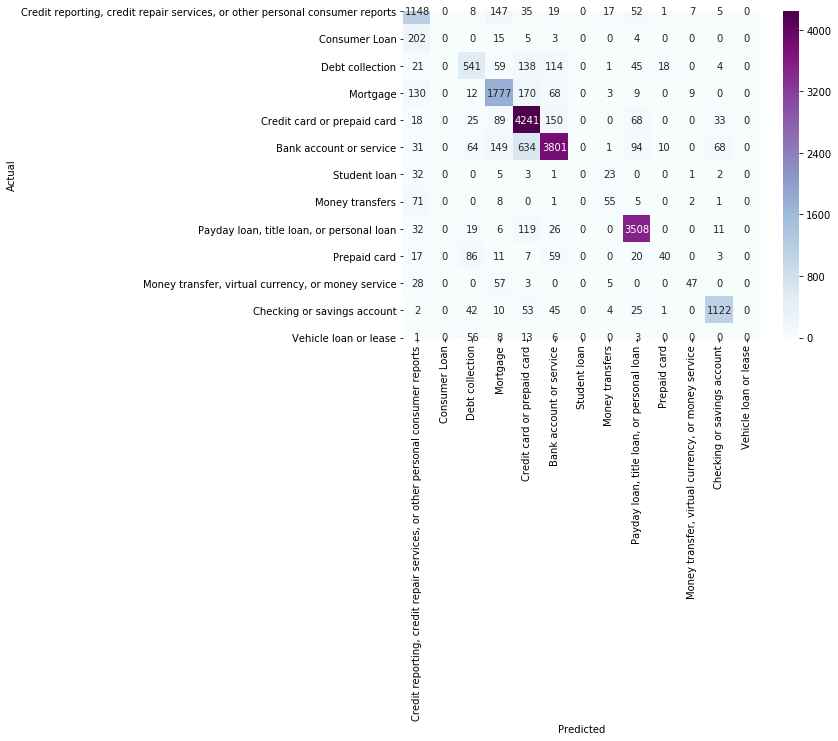

In [188]:
#  We see the same areas of difficulties as the previous models

y_train_predict_label_lstm_atten = np.argmax(np.asarray(y_predict_lstm_attention), axis = 1)
y_train_true_label_lstm_atten = np.argmax(np.asarray(Y_test), axis =1)

print(y_train_predict_label_lstm_atten)

print(y_train_true_label_lstm_atten)

result_table = confusion_matrix(y_train_true_label_lstm_atten, y_train_predict_label_lstm_atten)

fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(result_table, annot=True, fmt="d", cmap="BuPu",xticklabels=df['Product'].unique(),yticklabels=df['Product'].unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()